# Reacher

## Import

In [1]:
import sys
import random
from collections import namedtuple, deque

import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from unityagents import UnityEnvironment
from IPython.display import clear_output

from model import PPOPolicyNetwork
from agent import PPOAgent

## Create Unity environment

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Parameters

In [3]:
config = {
    'environment': {
        'state_size':  env_info.vector_observations.shape[1],
        'action_size': brain.vector_action_space_size,
        'number_of_agents': len(env_info.agents)
    },
    'pytorch': {
        'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    },
    'hyperparameters': {
        'discount_rate': 0.99,
        'tau': 0.95,
        'gradient_clip': 5,
        'rollout_length': 2048,
        'optimization_epochs': 10,
        'ppo_clip': 0.2,
        'log_interval': 2048,
        'max_steps': 1e5,
        'mini_batch_number': 32,
        'entropy_coefficent': 0.01,
        'episode_count': 250,
        'hidden_size': 512,
        'adam_learning_rate': 3e-4,
        'adam_epsilon': 1e-5
    }
}

## PPO

In [4]:
def play_round(env, brain_name, policy, config):
    env_info = env.reset(train_mode=True)[brain_name]    
    states = env_info.vector_observations                 
    scores = np.zeros(config['environment']['number_of_agents'])                         
    while True:
        actions, _, _, _ = policy(states)
        env_info = env.step(actions.cpu().detach().numpy())[brain_name]
        next_states = env_info.vector_observations         
        rewards = env_info.rewards                         
        dones = env_info.local_done                     
        scores += env_info.rewards                      
        states = next_states                               
        if np.any(dones):                                  
            break
    
    return np.mean(scores)
    
def ppo(env, brain_name, policy, config, train):
    if train:
        optimizier = optim.Adam(policy.parameters(), config['hyperparameters']['adam_learning_rate'], 
                        eps=config['hyperparameters']['adam_epsilon'])
        agent = PPOAgent(env, brain_name, policy, optimizier, config)
        all_scores = []
        averages = []
        last_max = 30.0
        
        for i in tqdm.tqdm(range(config['hyperparameters']['episode_count'])):
            agent.step()
            last_mean_reward = play_round(env, brain_name, policy, config)
            last_average = np.mean(np.array(all_scores[-100:])) if len(all_scores) > 100 else np.mean(np.array(all_scores))
            all_scores.append(last_mean_reward)
            averages.append(last_average)
            if last_average > last_max:
                torch.save(policy.state_dict(), f"ppo.pth")
                last_max = last_average
            clear_output(True)
            print('Episode: {} Total score: {} Last {} average: {}'.format(i + 1, last_mean_reward, min(i + 1, 100), last_average))
        return all_scores, averages
    else:
        score = play_round(env, brain_name, policy, config)
        return [score], [score]

## Train

In [5]:
new_policy = PPOPolicyNetwork(config)
all_scores, average_scores = ppo(env, brain_name, new_policy, config, train=True)

100%|██████████| 250/250 [30:55<00:00,  7.21s/it]

Episode: 250 Total score: 38.5364991386421 Last 100 average: 37.90468415276427


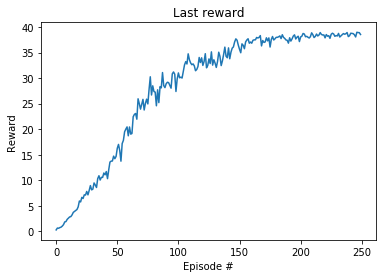

In [6]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
plt.plot(np.arange(len(all_scores)), all_scores)
plt.ylabel('Reward')
plt.xlabel('Episode #')
plt.title('Last reward')
plt.show()

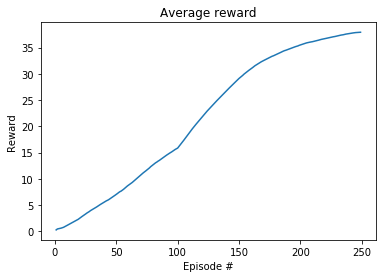

In [10]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
plt.plot(np.arange(len(average_scores)), average_scores)
plt.ylabel('Reward')
plt.xlabel('Episode #')
plt.title('Average reward')
plt.show()

## Run

In [8]:
policy = PPOPolicyNetwork(config)
policy.load_state_dict(torch.load('ppo.pth'))
run_all_scores, run_average_scores = ppo(env, brain_name, policy, config, train=False)

In [11]:
print(run_average_scores)

[38.75849913368002]


## Close Environment

In [12]:
env.close()